In [1]:
import subprocess
subprocess.check_output(["maturin", "develop"])
import time

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   --> src/ladder_filter.rs:131:8
    |
110 | impl LadderFilter {
    | ----------------- method in this implementation
...
131 |     fn run_ladder_nonlinear(&mut self, input: f64) {
    |        ^^^^^^^^^^^^^^^^^^^^
    |
    = note: `#[warn(dead_code)]` on by default

    Finished dev [unoptimized + debuginfo] target(s) in 0.02s
📦 Built wheel for CPython 3.10 to /tmp/.tmpyDHzh8/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


In [2]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import random
import PIL
from tqdm.notebook import tqdm
from copy import deepcopy
from IPython.display import clear_output
import librosa
from scipy.optimize import differential_evolution
import soundfile as sf
from multiprocessing import Pool
import os
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier, Sum, ADSR
from luthier.dsp import Sample
plt.rcParams['figure.dpi'] = 110
SAMPLE_RATE = 22050

Target sample rate 22050
Generator sample rate 22050


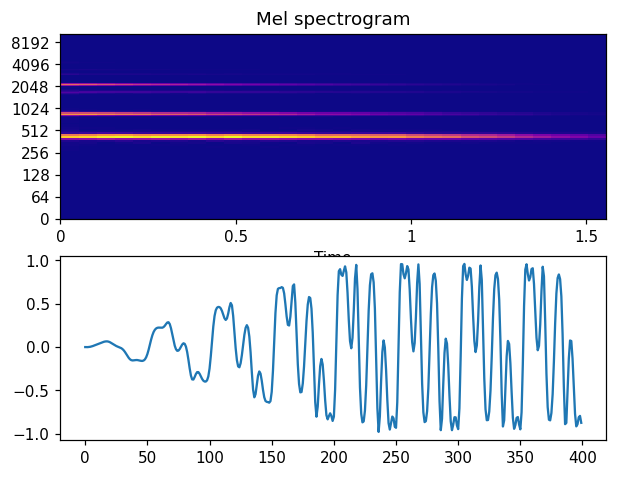

In [3]:
fm_sample_data, fm_sample_sample_rate = librosa.load('./fm_sample.wav')
print("Target sample rate", fm_sample_sample_rate)
print("Generator sample rate", SAMPLE_RATE)

fm_sample = Sample(fm_sample_data[100:])

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
fm_sample.plot_spectrogram(ax)
ax2.plot(fm_sample.buffer[:400])

fm_sample.show_player()

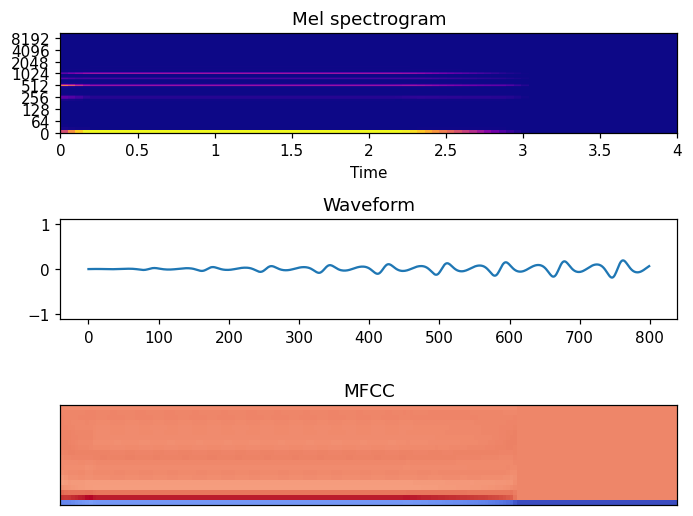

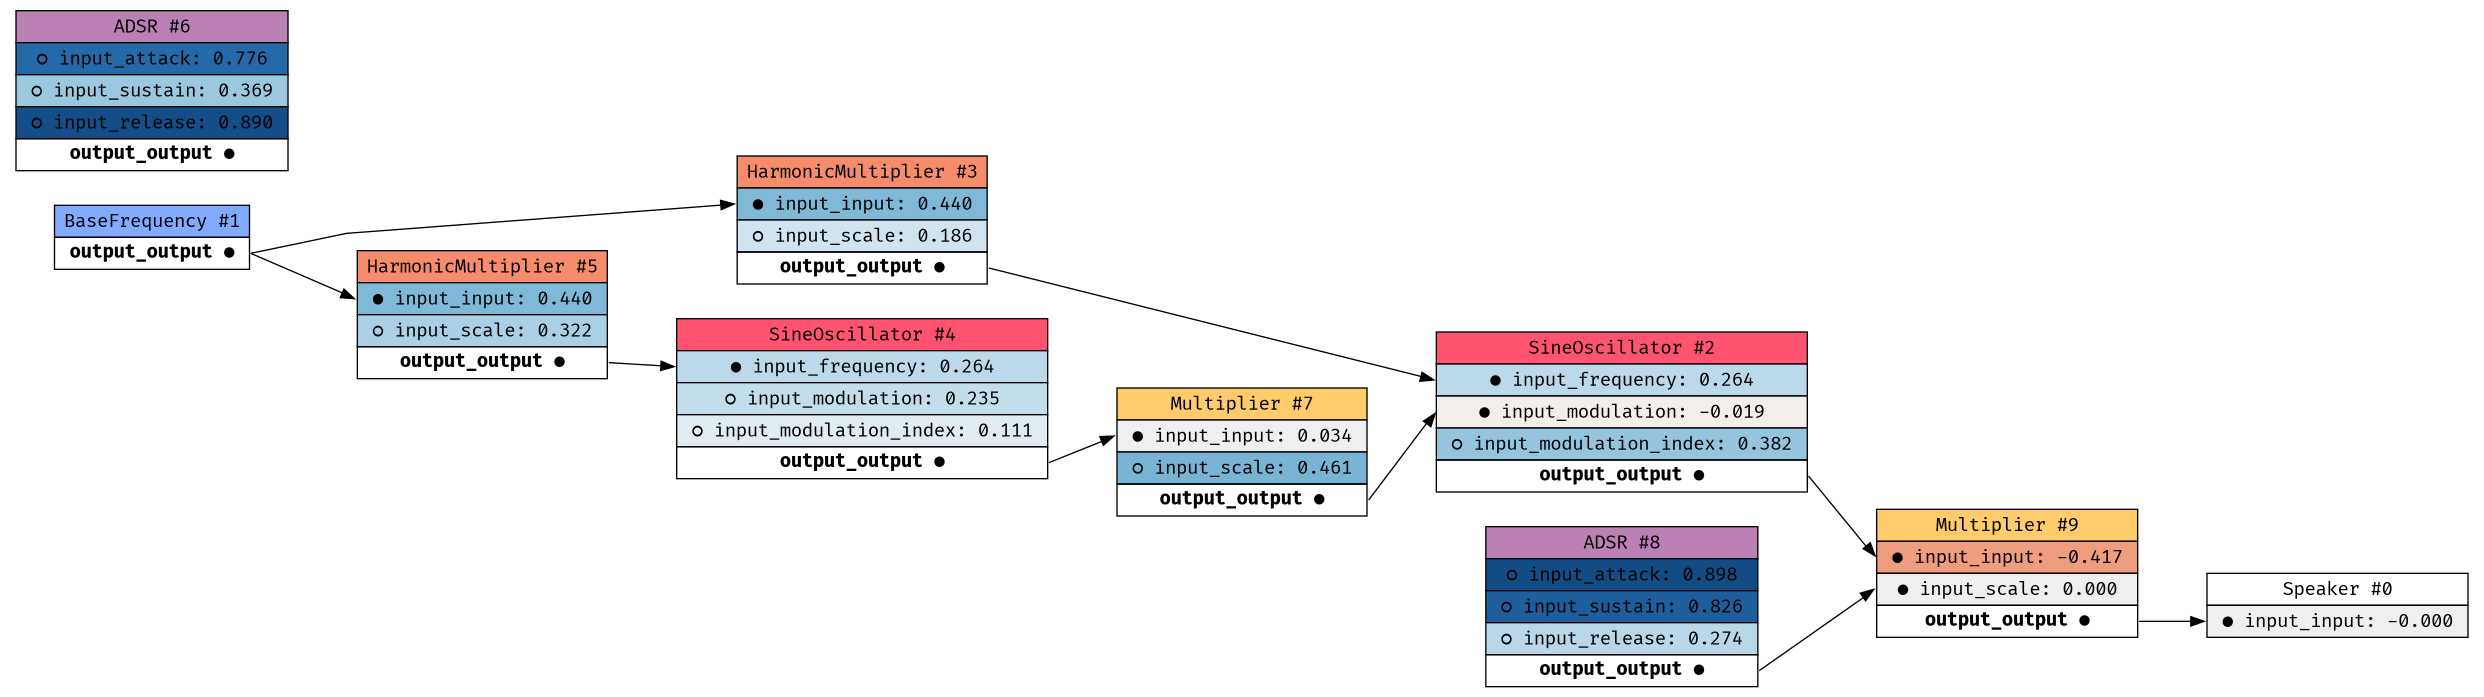

In [16]:
def make_fm_section(graph: DspGraph):
    carrier_id = graph.add_sine(SineOscillator())
    
    harmonic_mult = HarmonicMultiplier()
    harmonic_multiplier = graph.add_harmonic_multiplier(harmonic_mult)
    graph.patch(graph.base_frequency_node_id, "output_output", harmonic_multiplier, "input_input")
    graph.patch(harmonic_multiplier, "output_output", carrier_id, "input_frequency")
    
    modulator_id = graph.add_sine(SineOscillator())
    
    harmonic_mult = HarmonicMultiplier()
    harmonic_multiplier = graph.add_harmonic_multiplier(harmonic_mult)
    graph.patch(graph.base_frequency_node_id, "output_output", harmonic_multiplier, "input_input")
    graph.patch(harmonic_multiplier, "output_output", modulator_id, "input_frequency")
    
    modulator_adsr = graph.add_adsr(ADSR())
    modulator_mult = graph.add_multiplier(Multiplier())
    graph.patch(modulator_id, "output_output", modulator_mult, "input_input")
    graph.patch(modulator_mult, "output_output", carrier_id, "input_modulation")
    
    carrier_adsr = graph.add_adsr(ADSR())
    carrier_mult = graph.add_multiplier(Multiplier())
    graph.patch(carrier_adsr, "output_output", carrier_mult, "input_scale")
    graph.patch(carrier_id, "output_output", carrier_mult, "input_input")
    
    return carrier_mult


def complex_fm():
    graph = DspGraph()
    # graph.set_input(graph.amp_adsr_node_id, "input_attack", 0.001)
    # graph.set_input(graph.amp_adsr_node_id, "input_release", 0.401)
    # mixer = graph.add_sum(Sum())
    # graph.patch(mixer, "output_output", graph.amp_adsr_node_id, "input_input")

    fm_section = make_fm_section(graph)
    graph.patch(fm_section, "output_output", graph.speaker_node_id, "input_input")

    # fm_section = make_fm_section(graph)
    # graph.patch(fm_section, "output_output", mixer, "input_in_2")

#     fm_section = make_fm_section(graph)
#     graph.patch(fm_section, "output_output", mixer, "input_in_3")
    
    return graph

graph = complex_fm()
graph.set_inputs(np.array( [random.uniform(0, 1.0) for _ in range(graph.num_inputs())] ))
# graph.set_input(graph.amp_adsr_node_id, "input_attack", 0.0)
# graph.set_input(7, "input_attack", 0.0)

generated_audio = Sample(graph.play(SAMPLE_RATE * 4))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
generated_audio.plot_spectrogram(ax1)
generated_audio.plot_waveform(ax2, num_samples=800)
generated_audio.plot_mfcc(ax3)
generated_audio.show_player()
fig.tight_layout()
plt.show()

display(Image(graph.draw()))
distances = []

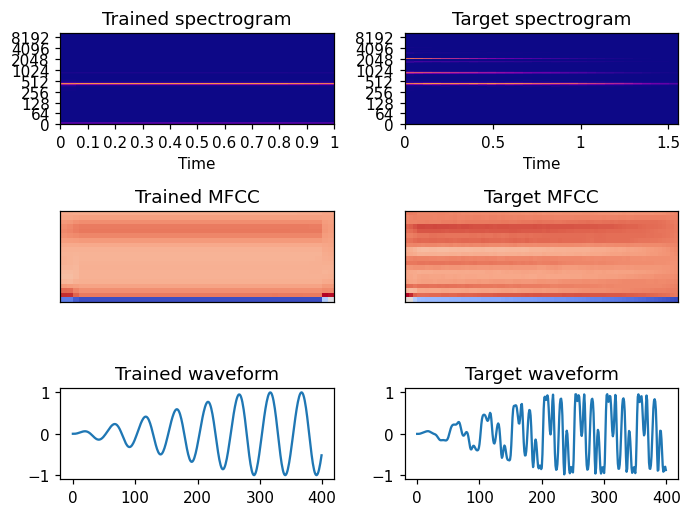

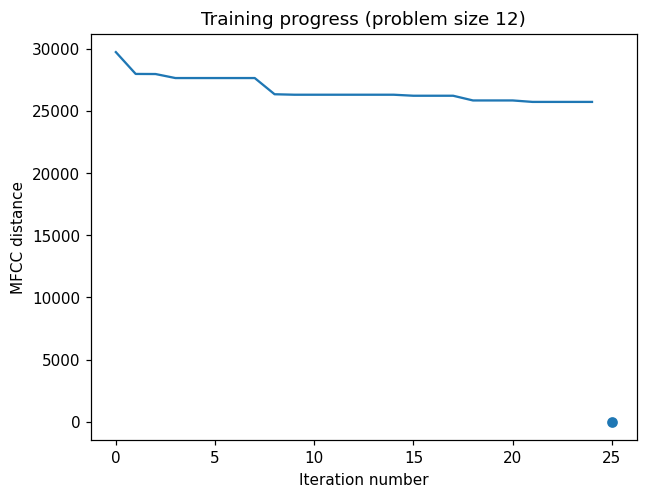

 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 25717.19405841698
       x: [-1.288e-01  3.632e-01 -2.311e-01  8.957e-02  4.197e-01
            5.976e-01 -1.116e-01  4.416e-01  6.012e-02  6.337e-02
            3.159e-01 -2.940e-01]
     nit: 25
    nfev: 12480


In [17]:
target_audio = fm_sample

MAX_ITERATIONS = 25
POPULATION_SIZE = 40

def optimise_freq_and_mod(x):
    graph = complex_fm()
    graph.set_inputs(x)
    generated_audio = Sample(graph.play(len(target_audio)))
    dist = target_audio.mfcc_distance(generated_audio)
    
    return dist

def show_comparison(x):
    graph = complex_fm()
    graph.set_inputs(x)

    generated_audio = Sample(graph.play(num_samples = SAMPLE_RATE * 1))
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=False, sharey=False)

    generated_audio.show_player()
    target_audio.show_player()

    generated_audio.plot_spectrogram(ax1, "Trained spectrogram")
    generated_audio.plot_waveform(ax5, title="Trained waveform")
    generated_audio.plot_mfcc(ax3, title="Trained MFCC")

    target_audio.plot_spectrogram(ax2, title="Target spectrogram")
    target_audio.plot_waveform(ax6, title="Target waveform")
    target_audio.plot_mfcc(ax4, title="Target MFCC")

    fig.tight_layout()
    # plt.savefig(f'{time.time()}.png')
    plt.show()

target_fun_values = []
def callback(x, convergence):
    clear_output()
    target_fun = optimise_freq_and_mod(x)
    target_fun_values.append(target_fun)
    show_comparison(x)
    plt.plot(target_fun_values)
    plt.scatter(MAX_ITERATIONS, 0)
    plt.title(f"Training progress (problem size {len(x)})")
    plt.xlabel("Iteration number")
    plt.ylabel("MFCC distance")
    plt.show()

num_params = complex_fm().num_inputs()
print("Solving for num inputs", num_params)
solution = differential_evolution(
    optimise_freq_and_mod,
    [ (-1, 1) for i in range(num_params) ],
    workers=8,
    maxiter=MAX_ITERATIONS,
    popsize=POPULATION_SIZE,
    polish=False,
    disp=False,
    callback=callback
)
print(solution)

In [ ]:
x = solution.x

g = complex_fm()
g.set_inputs(x)
display(Image(g.draw()))
audio = Sample(g.play(SAMPLE_RATE))
audio.show_player()